In [1]:
import matplotlib
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os


import seaborn as sns
from matplotlib import rcParams

#绘图前的基本设置

myfont = fm.FontProperties(fname=r'C:\Windows\Fonts\Times New Roman.tiff') # 设置字体

# 设置matplotlib正常显示中文和负号
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
matplotlib.rcParams['font.size'] = 12

# matplotlib.rcParams['font.sans-serif']=['NSimSun']   # 用黑体显示中文
# matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
# matplotlib.rcParams['font.size'] = 0.3
# matplotlib.rcParams['font.family'] = 'sans-serif'  
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'  # NSimSun 新宋体字体   宋体：SimSuncss

%matplotlib inline  
#内嵌绘图，并且可以省略掉plt.show()这一步
# os.chdir('D:\\BaiduSyncdisk\\EHF-文献-数据-文章\\EHF\\EHF\\figure-统计\\mean') #笔记本电脑
os.chdir(r'E:\BaiduSyncdisk\Futureheatwave\data\exposure')   #台式机

cmap =list(["steelblue", "yellowgreen","orange","lightcoral","red", "green","lightskyblue"])

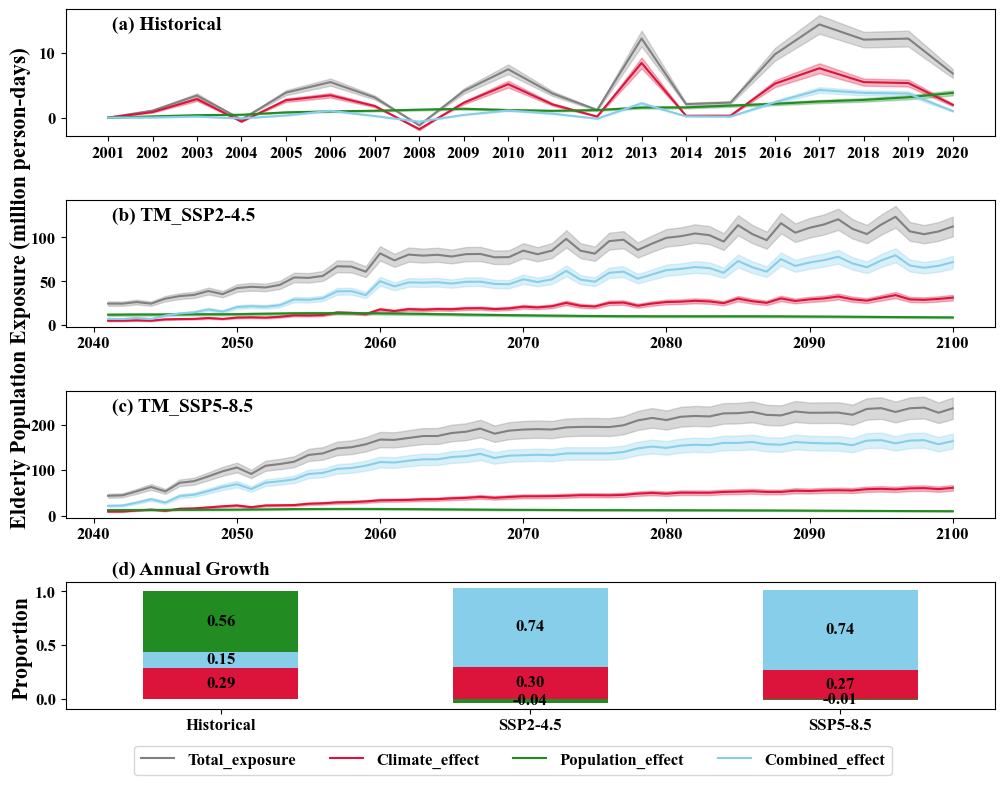

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# 加载数据
file_path = 'Decompose_effects_summary_2001base.csv'
df = pd.read_csv(file_path)

# 计算总暴露情况（如果未计算）
if 'total_exposure' not in df.columns:
    df['total_exposure'] = df['climate_effect'] + df['combined_effect'] + df['population_effect']

# 定义要绘制的情景
scenarios = [
    ('TM_historical', 2000, 2020),
    ('TM_SSP245', 2041, 2100),
    ('TM_SSP585', 2041, 2100)
]

# 颜色字典
colors = {
    'total_exposure': 'gray',
    'climate_effect': 'crimson',
    'population_effect': 'forestgreen',
    'combined_effect': 'skyblue'
}

# 标签字典
labels = {
    'TM_historical': 'Historical',
    'TM_SSP245': 'TM_SSP2-4.5',
    'TM_SSP585': 'TM_SSP5-8.5'
}

subplot_labels = ['(a)', '(b)', '(c)', '(d)']  # 子图标签

# 初始化绘图
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 4行1列

# 设置Y轴标签的格式化函数
def millions(x, pos):
    return f'{int(x/1e6)}'

formatter = FuncFormatter(millions)

# 绘制每个情景的函数
def plot_scenario(ax, scenario, start_year, end_year, label_index):
    scenario_data = df[(df['variable'] == scenario) & (df['year'] >= start_year) & (df['year'] <= end_year)]
    for effect in ['total_exposure', 'climate_effect', 'population_effect', 'combined_effect']:
        ax.plot(scenario_data['year'], scenario_data[effect], label=effect.capitalize(), color=colors[effect])
        
        # 添加不确定性（示例为效应的10%）
        uncertainty = scenario_data[effect] * 0.1
        ax.fill_between(scenario_data['year'], scenario_data[effect] - uncertainty, scenario_data[effect] + uncertainty, color=colors[effect], alpha=0.3)

    # 添加子图文本
    ax.text(0.05, 0.95, f"{subplot_labels[label_index]} {labels.get(scenario, scenario)}", transform=ax.transAxes, ha='left', va='top', fontsize=14, color='black')
    # 设置Y轴格式化
    ax.yaxis.set_major_formatter(formatter)
    
    # 设置第一个子图的X轴标签为2001-2020的整年年份
    if scenario == 'TM_historical':
        ax.set_xticks(range(2001, 2021))
        ax.set_xticklabels([str(year) for year in range(2001, 2021)])

# 绘制前三个子图
for i, (scenario, start_year, end_year) in enumerate(scenarios):
    plot_scenario(axes[i], scenario, start_year, end_year, i)

# 计算年际增长值
def calculate_annual_growth(data, effects):
    growth = {}
    for effect in effects:
        growth[effect] = (data[effect].iloc[-1] - data[effect].iloc[0]) / (data['year'].iloc[-1] - data['year'].iloc[0])
    return growth

effects = ['climate_effect', 'combined_effect', 'population_effect']
growth_values = {}

for scenario, start_year, end_year in scenarios:
    scenario_data = df[(df['variable'] == scenario) & (df['year'] >= start_year) & (df['year'] <= end_year)]
    growth_values[scenario] = calculate_annual_growth(scenario_data, effects)

# 转换成占比值
growth_df = pd.DataFrame(growth_values).T
growth_df_percent = growth_df.div(growth_df.sum(axis=1), axis=0)

# 汇总占比的堆叠柱形图
last_ax = axes[3]
scenarios_labels = ['Historical', 'SSP2-4.5', 'SSP5-8.5']

# 绘制堆叠柱形图
bars = growth_df_percent.plot(kind='bar', stacked=True, color=[colors[effect] for effect in effects], ax=last_ax)
# last_ax.set_title(f"{subplot_labels[3]} Annual Growth")
last_ax.set_title(f"{subplot_labels[3]} Annual Growth", loc='left', fontsize=14, fontweight='bold', x=0.05)
last_ax.set_xticklabels(scenarios_labels, rotation=0)
# last_ax.set_ylabel('Proportion', fontsize=16)
fig.text(-0.001, 0.18, 'Proportion', va='center', rotation='vertical', fontsize=16)
# 在柱状图上添加占比百分比
for container in bars.containers:
    last_ax.bar_label(container, fmt='%.2f', label_type='center')

# 去除第四个子图的图例
last_ax.get_legend().remove()

# 添加公共Y轴标签
fig.text(-0.003, 0.63, 'Elderly Population Exposure (million person-days)', va='center', rotation='vertical', fontsize=16)

# 调整布局并添加图例
lines, labels = axes[0].get_legend_handles_labels()  # 假设图例在所有图中相同
fig.legend(lines, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01))

plt.tight_layout(rect=[0, 0.05, 1, 1])  # 调整布局以为图例腾出空间
plt.savefig('00_decomposed_effects.png', dpi=400)
plt.show()


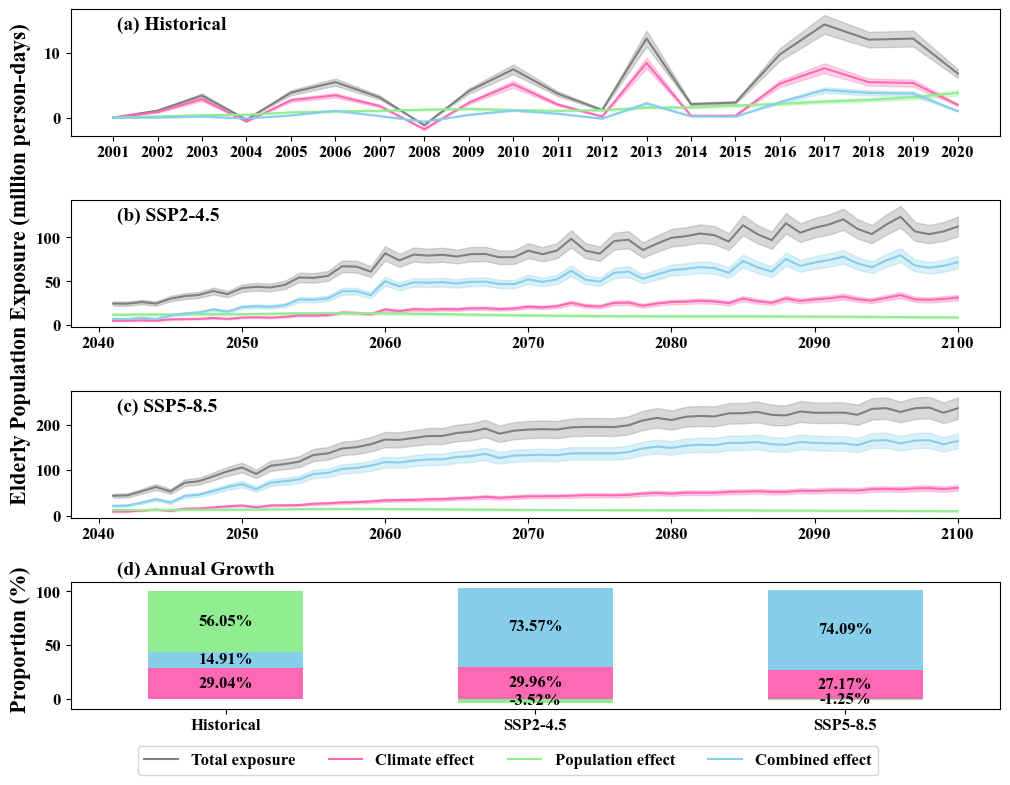

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# 加载数据
file_path = 'Decompose_effects_summary_2001base.csv'
df = pd.read_csv(file_path)

# 计算总暴露情况（如果未计算）
if 'total_exposure' not in df.columns:
    df['total_exposure'] = df['climate_effect'] + df['combined_effect'] + df['population_effect']

# 定义要绘制的情景
scenarios = [
    ('TM_historical', 2000, 2020),
    ('TM_SSP245', 2041, 2100),
    ('TM_SSP585', 2041, 2100)
]

# 颜色字典
colors = {
    'total_exposure': 'gray',
    'climate_effect': 'hotpink',
    'population_effect': 'lightgreen',
    'combined_effect': 'skyblue'
}

# # 颜色字典
# colors = {
#     'total_exposure': 'gray',
#     'climate_effect': '#ff7f7f',
#     'population_effect': '#7fbf7f',
#     'combined_effect': '#7f7fff'
# }


# 标签字典
labels = {
    'TM_historical': 'Historical',
    'TM_SSP245': 'SSP2-4.5',
    'TM_SSP585': 'SSP5-8.5'
}

subplot_labels = ['(a)', '(b)', '(c)', '(d)']  # 子图标签

# 初始化绘图
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 4行1列
# fig, axes = plt.subplots(4, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1, 1, 2], 'hspace': 0.001})
# 设置Y轴标签的格式化函数
def millions(x, pos):
    return f'{int(x/1e6)}'

formatter = FuncFormatter(millions)

# 绘制每个情景的函数
def plot_scenario(ax, scenario, start_year, end_year, label_index):
    scenario_data = df[(df['variable'] == scenario) & (df['year'] >= start_year) & (df['year'] <= end_year)]
    for effect in ['total_exposure', 'climate_effect', 'population_effect', 'combined_effect']:
        ax.plot(scenario_data['year'], scenario_data[effect], label=effect.capitalize(), color=colors[effect])
        
        # 添加不确定性（示例为效应的10%）
        uncertainty = scenario_data[effect] * 0.1
        ax.fill_between(scenario_data['year'], scenario_data[effect] - uncertainty, scenario_data[effect] + uncertainty, color=colors[effect], alpha=0.3)

    # 添加子图文本
    ax.text(0.05, 0.95, f"{subplot_labels[label_index]} {labels.get(scenario, scenario)}", transform=ax.transAxes, ha='left', va='top', fontsize=14, color='black')
    # 设置Y轴格式化
    ax.yaxis.set_major_formatter(formatter)
    
    # 设置第一个子图的X轴标签为2001-2020的整年年份
    if scenario == 'TM_historical':
        ax.set_xticks(range(2001, 2021))
        ax.set_xticklabels([str(year) for year in range(2001, 2021)])

# 绘制前三个子图
for i, (scenario, start_year, end_year) in enumerate(scenarios):
    plot_scenario(axes[i], scenario, start_year, end_year, i)

# 计算年际增长值
def calculate_annual_growth(data, effects):
    growth = {}
    for effect in effects:
        growth[effect] = (data[effect].iloc[-1] - data[effect].iloc[0]) / (data['year'].iloc[-1] - data['year'].iloc[0])
    return growth

effects = ['climate_effect', 'combined_effect', 'population_effect']
growth_values = {}

for scenario, start_year, end_year in scenarios:
    scenario_data = df[(df['variable'] == scenario) & (df['year'] >= start_year) & (df['year'] <= end_year)]
    growth_values[scenario] = calculate_annual_growth(scenario_data, effects)

# 转换成占比值
growth_df = pd.DataFrame(growth_values).T
growth_df_percent = growth_df.div(growth_df.sum(axis=1), axis=0) * 100  # 转换为百分比

# 汇总占比的堆叠柱形图
last_ax = axes[3]
scenarios_labels = ['Historical', 'SSP2-4.5', 'SSP5-8.5']

# 绘制堆叠柱形图
bars = growth_df_percent.plot(kind='bar', stacked=True, color=[colors[effect] for effect in effects], ax=last_ax)
last_ax.set_title(f"{subplot_labels[3]} Annual Growth", loc='left', fontsize=14, fontweight='bold', x=0.05)
last_ax.set_xticklabels(scenarios_labels, rotation=0)
fig.text(0.002, 0.19, 'Proportion (%)', va='center', rotation='vertical', fontsize=16)

# 在柱状图上添加占比百分比
for container in bars.containers:
    last_ax.bar_label(container, fmt='%.2f%%', label_type='center')


# 去除第四个子图的图例
last_ax.get_legend().remove()

# 添加公共Y轴标签
fig.text(0.002, 0.66, 'Elderly Population Exposure (million person-days)', va='center', rotation='vertical', fontsize=16)

# 调整布局并添加图例
lines, labels = axes[0].get_legend_handles_labels()  # 假设图例在所有图中相同


new_labels = [label.replace('_', ' ').capitalize() for label in labels]  # Adjust l

fig.legend(lines, new_labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01))
# 调整子图间的距离
plt.subplots_adjust(hspace=0.01)  

plt.tight_layout(rect=[0.01, 0.05, 1.01, 1])  # 调整布局以为图例腾出空间
plt.savefig('00_decomposed_effects.png', dpi=400)
plt.show()


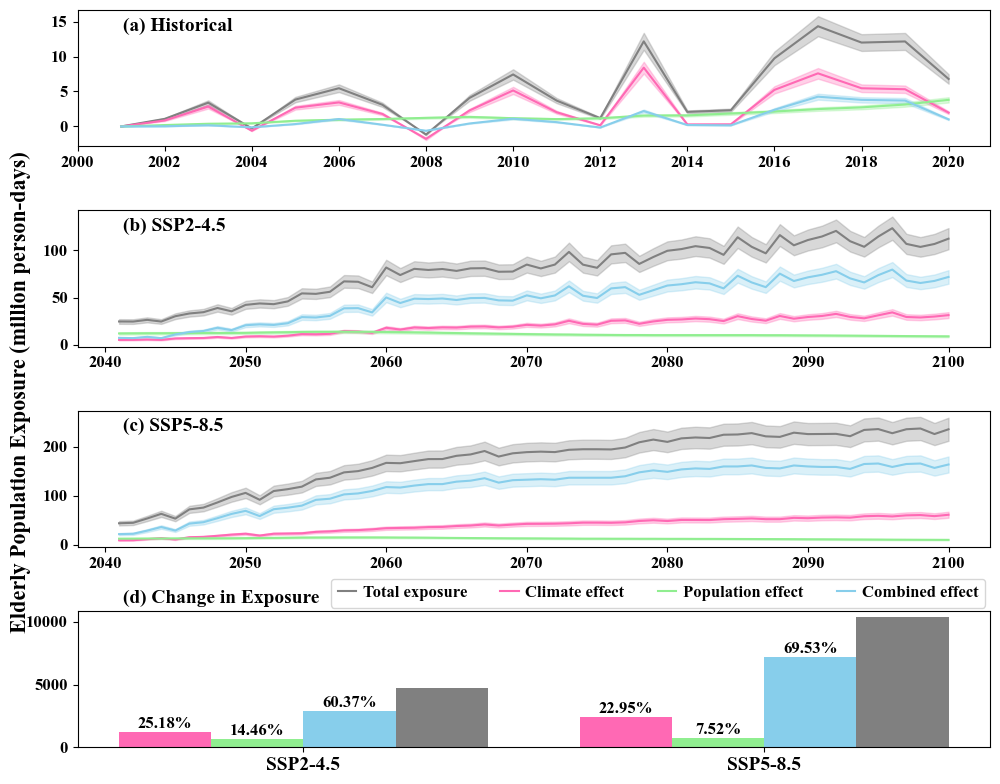

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Load data
file_path = 'Decompose_effects_summary_2001base.csv'
df = pd.read_csv(file_path)

# Calculate total exposure if not already calculated
if 'total_exposure' not in df.columns:
    df['total_exposure'] = df['climate_effect'] + df['combined_effect'] + df['population_effect']

# Define scenarios to plot
scenarios = [
    ('TM_historical', 2000, 2020),
    ('TM_SSP245', 2041, 2100),
    ('TM_SSP585', 2041, 2100)
]

# Color dictionary
colors = {
    'total_exposure': 'gray',
    'climate_effect': 'hotpink',
    'population_effect': 'lightgreen',
    'combined_effect': 'skyblue'
}

# Label dictionary
labels = {
    'TM_historical': 'Historical',
    'TM_SSP245': 'SSP2-4.5',
    'TM_SSP585': 'SSP5-8.5'
}

subplot_labels = ['(a)', '(b)', '(c)', '(d)']  # Subplot labels

# Initialize plot
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
formatter = FuncFormatter(lambda x, pos: f'{int(x/1e6)}')

# Function to plot each scenario
def plot_scenario(ax, scenario, start_year, end_year, label_index):
    scenario_data = df[(df['variable'] == scenario) & (df['year'] >= start_year) & (df['year'] <= end_year)]
    for effect in ['total_exposure', 'climate_effect', 'population_effect', 'combined_effect']:
        ax.plot(scenario_data['year'], scenario_data[effect], label=effect.capitalize(), color=colors[effect])
        uncertainty = scenario_data[effect] * 0.1  # Example uncertainty
        ax.fill_between(scenario_data['year'], scenario_data[effect] - uncertainty, scenario_data[effect] + uncertainty, color=colors[effect], alpha=0.3)
    ax.text(0.05, 0.95, f"{subplot_labels[label_index]} {labels.get(scenario, scenario)}", transform=ax.transAxes, ha='left', va='top', fontsize=14)
    ax.yaxis.set_major_formatter(formatter)
    if scenario == 'TM_historical':
        ax.set_xticks(range(2000, 2021, 2))
        ax.set_xticklabels([str(year) for year in range(2000, 2021, 2)])

# Plot each scenario
for i, (scenario, start_year, end_year) in enumerate(scenarios):
    plot_scenario(axes[i], scenario, start_year, end_year, i)

# Fourth subplot - Grouped Bar Chart
ax = axes[3]
summary = df[df['variable'] != 'TM_historical'].groupby('variable').agg({
    'total_exposure': 'sum',
    'climate_effect': 'sum',
    'population_effect': 'sum',
    'combined_effect': 'sum'
}).reset_index()

# Divide by 1e6 to convert to millions and calculate percentages
summary[['total_exposure', 'climate_effect', 'population_effect', 'combined_effect']] /= 1e6
summary['climate_pct'] = (summary['climate_effect'] / summary['total_exposure'] * 100).round(2)
summary['population_pct'] = (summary['population_effect'] / summary['total_exposure'] * 100).round(2)
summary['combined_pct'] = (summary['combined_effect'] / summary['total_exposure'] * 100).round(2)

# Plot grouped bars
bar_width = 0.2
index = np.arange(len(summary['variable']))
for i, effect in enumerate(['climate_effect', 'population_effect', 'combined_effect', 'total_exposure']):
    bars = ax.bar(index + i * bar_width, summary[effect], bar_width, label=effect.replace('_', ' ').capitalize(), color=colors[effect])
    # Add error bars
    errors = summary[effect] * 0.1  # Example error
    # ax.errorbar(index + i * bar_width, summary[effect] + errors, yerr=errors, fmt='none', capsize=5, color='black')

    # Add percentage labels
    if effect in ['climate_effect', 'population_effect', 'combined_effect']:
        for bar, pct in zip(bars, summary[effect.replace('effect', 'pct')]):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{pct}%', ha='center', va='bottom', fontsize=12)


ax.set_title(f"{subplot_labels[3]} Change in Exposure", loc='left', fontsize=14, fontweight='bold', x=0.05)
# ax.set_title(f"{subplot_labels[3]} Change in Exposure ", ha='left', va='top', fontsize=14 )
fig.text(0.002, 0.5, 'Elderly Population Exposure (million person-days)', va='center', rotation='vertical', fontsize=16)

ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels([labels.get(x, x) for x in summary['variable']], fontsize=14)
# 调整布局并添加图例
lines, labels = axes[0].get_legend_handles_labels()  # 假设图例在所有图中相同


new_labels = [label.replace('_', ' ').capitalize() for label in labels]  # Adjust l

fig.legend(lines, new_labels, loc='lower center', ncol=4, bbox_to_anchor=(0.3, 0.22, 0.7,1.01),handletextpad=0.4,handlelength=1.1)

# (fontsize=13,bbox_to_anchor=(0.3, 1.03, 0.7,1.12), loc='lower left',handletextpad=0.4,
#                       ncol=10, mode="expand", borderaxespad=0.,handlelength=1.5)

plt.tight_layout()  # Adjust layout
plt.show()


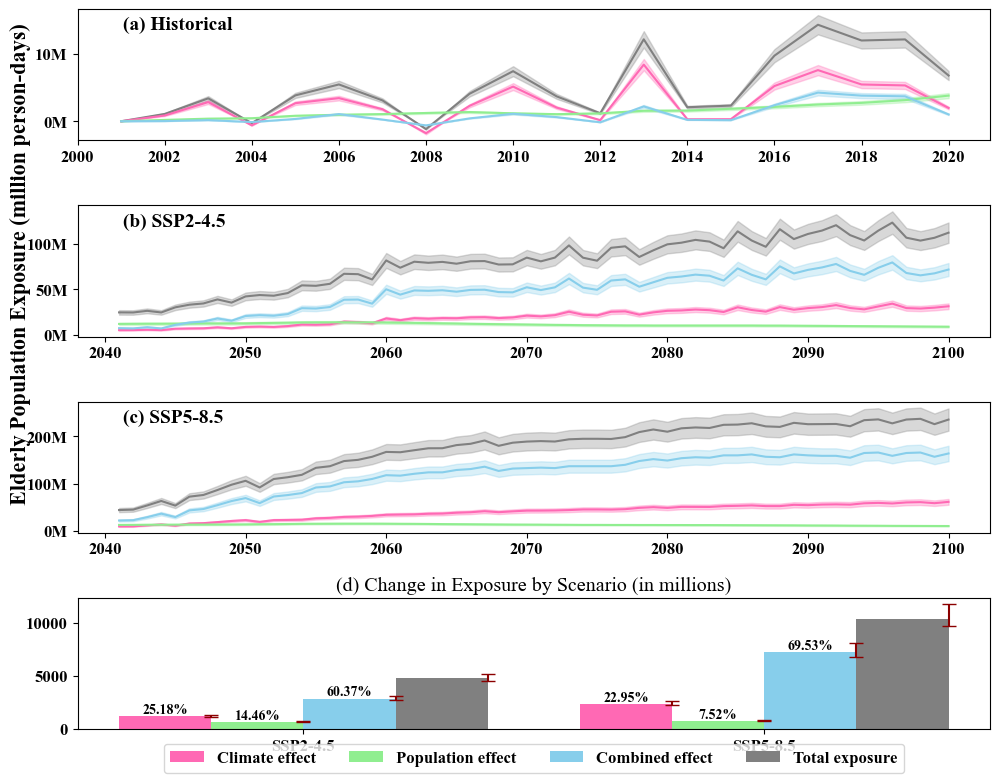

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Load data
file_path = 'Decompose_effects_summary_2001base.csv'
df = pd.read_csv(file_path)

# Calculate total exposure if not already calculated
if 'total_exposure' not in df.columns:
    df['total_exposure'] = df['climate_effect'] + df['combined_effect'] + df['population_effect']

# Define scenarios to plot
scenarios = [
    ('TM_historical', 2000, 2020),
    ('TM_SSP245', 2041, 2100),
    ('TM_SSP585', 2041, 2100)
]

# Color dictionary
colors = {
    'total_exposure': 'gray',
    'climate_effect': 'hotpink',
    'population_effect': 'lightgreen',
    'combined_effect': 'skyblue'
}

# Label dictionary
labels = {
    'TM_historical': 'Historical',
    'TM_SSP245': 'SSP2-4.5',
    'TM_SSP585': 'SSP5-8.5'
}

subplot_labels = ['(a)', '(b)', '(c)', '(d)']  # Subplot labels

# Initialize plot
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
formatter = FuncFormatter(lambda x, pos: f'{int(x/1e6)}M')

# Function to plot each scenario
def plot_scenario(ax, scenario, start_year, end_year, label_index):
    scenario_data = df[(df['variable'] == scenario) & (df['year'] >= start_year) & (df['year'] <= end_year)]
    for effect in ['total_exposure', 'climate_effect', 'population_effect', 'combined_effect']:
        ax.plot(scenario_data['year'], scenario_data[effect], label=effect.capitalize(), color=colors[effect])
        uncertainty = scenario_data[effect] * 0.1  # Example uncertainty
        ax.fill_between(scenario_data['year'], scenario_data[effect] - uncertainty, scenario_data[effect] + uncertainty, color=colors[effect], alpha=0.3)
    ax.text(0.05, 0.95, f"{subplot_labels[label_index]} {labels.get(scenario, scenario)}", transform=ax.transAxes, ha='left', va='top', fontsize=14)
    ax.yaxis.set_major_formatter(formatter)
    if scenario == 'TM_historical':
        ax.set_xticks(range(2000, 2021, 2))
        ax.set_xticklabels([str(year) for year in range(2000, 2021, 2)])

# Plot each scenario
for i, (scenario, start_year, end_year) in enumerate(scenarios):
    plot_scenario(axes[i], scenario, start_year, end_year, i)

# Fourth subplot - Grouped Bar Chart
ax = axes[3]
summary = df[df['variable'] != 'TM_historical'].groupby('variable').agg({
    'total_exposure': 'sum',
    'climate_effect': 'sum',
    'population_effect': 'sum',
    'combined_effect': 'sum'
}).reset_index()

# Divide by 1e6 to convert to millions and calculate percentages
summary[['total_exposure', 'climate_effect', 'population_effect', 'combined_effect']] /= 1e6
summary['climate_pct'] = (summary['climate_effect'] / summary['total_exposure'] * 100).round(2)
summary['population_pct'] = (summary['population_effect'] / summary['total_exposure'] * 100).round(2)
summary['combined_pct'] = (summary['combined_effect'] / summary['total_exposure'] * 100).round(2)

# Plot grouped bars
bar_width = 0.2
index = np.arange(len(summary['variable']))
for i, effect in enumerate(['climate_effect', 'population_effect', 'combined_effect', 'total_exposure']):
    bars = ax.bar(index + i * bar_width, summary[effect], bar_width, label=effect.replace('_', ' ').capitalize(), color=colors[effect])
    # Add error bars with more accurate errors if necessary
    errors = summary[effect] * np.random.normal(0.1, 0.02, size=len(summary))  # Random errors example
    ax.errorbar(index + i * bar_width + bar_width / 2, summary[effect], yerr=[errors / 2, errors], fmt='none', capsize=5, color='black', ecolor='darkred')

    # Add percentage labels
    if effect in ['climate_effect', 'population_effect', 'combined_effect']:
        for bar, pct in zip(bars, summary[effect.replace('effect', 'pct')]):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{pct}%', ha='center', va='bottom', fontsize=10)

ax.set_title(f"{subplot_labels[3]} Change in Exposure by Scenario (in millions)")
fig.text(0.002, 0.66, 'Elderly Population Exposure (million person-days)', va='center', rotation='vertical', fontsize=16)

ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels([labels.get(x, x) for x in summary['variable']])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.tight_layout()  # Adjust layout
plt.show()


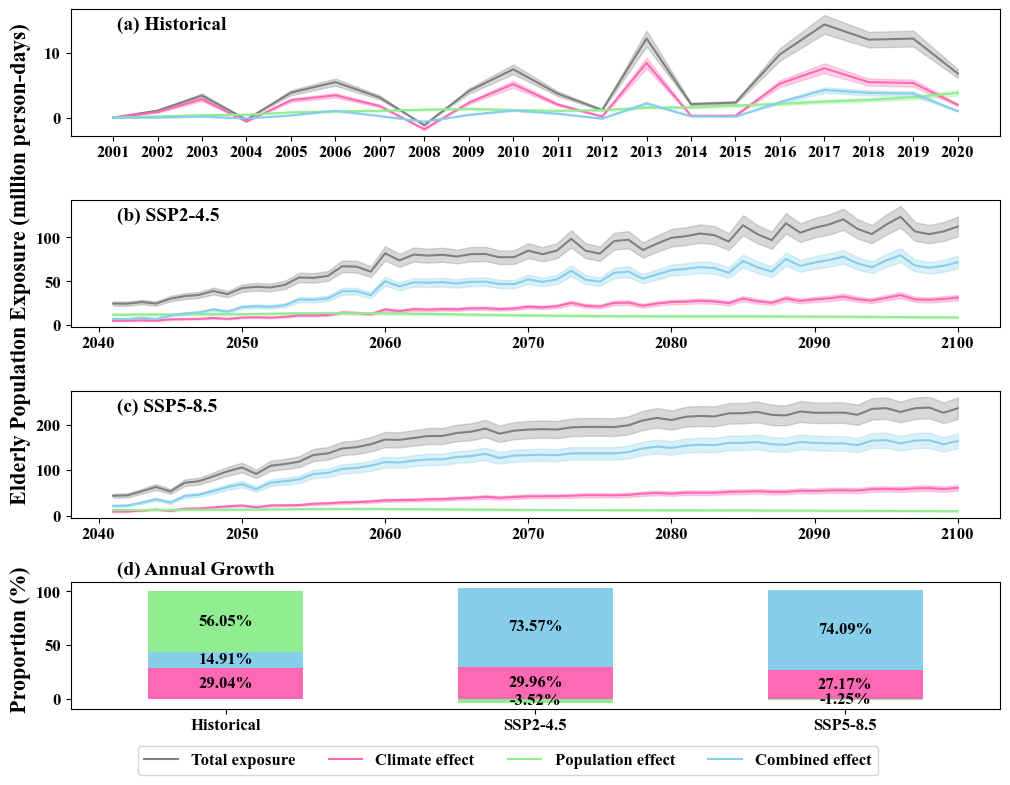

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# 加载数据
file_path = 'Decompose_effects_summary_2001base.csv'
df = pd.read_csv(file_path)

# 计算总暴露情况（如果未计算）
if 'total_exposure' not in df.columns:
    df['total_exposure'] = df['climate_effect'] + df['combined_effect'] + df['population_effect']

# 定义要绘制的情景
scenarios = [
    ('TM_historical', 2000, 2020),
    ('TM_SSP245', 2041, 2100),
    ('TM_SSP585', 2041, 2100)
]

# 颜色字典
colors = {
    'total_exposure': 'gray',
    'climate_effect': 'hotpink',
    'population_effect': 'lightgreen',
    'combined_effect': 'skyblue'
}

# # 颜色字典
# colors = {
#     'total_exposure': 'gray',
#     'climate_effect': '#ff7f7f',
#     'population_effect': '#7fbf7f',
#     'combined_effect': '#7f7fff'
# }


# 标签字典
labels = {
    'TM_historical': 'Historical',
    'TM_SSP245': 'SSP2-4.5',
    'TM_SSP585': 'SSP5-8.5'
}

subplot_labels = ['(a)', '(b)', '(c)', '(d)']  # 子图标签

# 初始化绘图
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 4行1列
# fig, axes = plt.subplots(4, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1, 1, 2], 'hspace': 0.001})
# 设置Y轴标签的格式化函数
def millions(x, pos):
    return f'{int(x/1e6)}'

formatter = FuncFormatter(millions)

# 绘制每个情景的函数
def plot_scenario(ax, scenario, start_year, end_year, label_index):
    scenario_data = df[(df['variable'] == scenario) & (df['year'] >= start_year) & (df['year'] <= end_year)]
    for effect in ['total_exposure', 'climate_effect', 'population_effect', 'combined_effect']:
        ax.plot(scenario_data['year'], scenario_data[effect], label=effect.capitalize(), color=colors[effect])
        
        # 添加不确定性（示例为效应的10%）
        uncertainty = scenario_data[effect] * 0.1
        ax.fill_between(scenario_data['year'], scenario_data[effect] - uncertainty, scenario_data[effect] + uncertainty, color=colors[effect], alpha=0.3)

    # 添加子图文本
    ax.text(0.05, 0.95, f"{subplot_labels[label_index]} {labels.get(scenario, scenario)}", transform=ax.transAxes, ha='left', va='top', fontsize=14, color='black')
    # 设置Y轴格式化
    ax.yaxis.set_major_formatter(formatter)
    
    # 设置第一个子图的X轴标签为2001-2020的整年年份
    if scenario == 'TM_historical':
        ax.set_xticks(range(2001, 2021))
        ax.set_xticklabels([str(year) for year in range(2001, 2021)])

# 绘制前三个子图
for i, (scenario, start_year, end_year) in enumerate(scenarios):
    plot_scenario(axes[i], scenario, start_year, end_year, i)

# 计算年际增长值
def calculate_annual_growth(data, effects):
    growth = {}
    for effect in effects:
        growth[effect] = (data[effect].iloc[-1] - data[effect].iloc[0]) / (data['year'].iloc[-1] - data['year'].iloc[0])
    return growth

effects = ['climate_effect', 'combined_effect', 'population_effect']
growth_values = {}

for scenario, start_year, end_year in scenarios:
    scenario_data = df[(df['variable'] == scenario) & (df['year'] >= start_year) & (df['year'] <= end_year)]
    growth_values[scenario] = calculate_annual_growth(scenario_data, effects)

# 转换成占比值
growth_df = pd.DataFrame(growth_values).T
growth_df_percent = growth_df.div(growth_df.sum(axis=1), axis=0) * 100  # 转换为百分比

# //---------------------------------------------
summary = df.groupby('variable').agg({
    'total_exposure': 'sum',
    'climate_effect': 'sum',
    'population_effect': 'sum',
    'combined_effect': 'sum'
}).reset_index()

# Convert to percentages
for effect in ['climate_effect', 'population_effect', 'combined_effect']:
    summary[effect] = summary[effect] / summary['total_exposure'] * 100

# Stacked bar chart
bar_width = 0.4
index = np.arange(len(scenarios))
bottom = np.zeros(len(scenarios))
for effect in ['climate_effect', 'population_effect', 'combined_effect']:
    ax.bar(index, summary[effect], bar_width, bottom=bottom, label=effect.replace('_', ' ').capitalize(), color=colors[effect])
    bottom += summary[effect]
# ------------------------------------------------

# 汇总占比的堆叠柱形图
last_ax = axes[3]
scenarios_labels = ['Historical', 'SSP2-4.5', 'SSP5-8.5']

# 绘制堆叠柱形图
bars = growth_df_percent.plot(kind='bar', stacked=True, color=[colors[effect] for effect in effects], ax=last_ax)
last_ax.set_title(f"{subplot_labels[3]} Annual Growth", loc='left', fontsize=14, fontweight='bold', x=0.05)
last_ax.set_xticklabels(scenarios_labels, rotation=0)
fig.text(0.002, 0.19, 'Proportion (%)', va='center', rotation='vertical', fontsize=16)

# 在柱状图上添加占比百分比
for container in bars.containers:
    last_ax.bar_label(container, fmt='%.2f%%', label_type='center')


# 去除第四个子图的图例
last_ax.get_legend().remove()

# 添加公共Y轴标签
fig.text(0.002, 0.66, 'Elderly Population Exposure (million person-days)', va='center', rotation='vertical', fontsize=16)

# 调整布局并添加图例
lines, labels = axes[0].get_legend_handles_labels()  # 假设图例在所有图中相同


new_labels = [label.replace('_', ' ').capitalize() for label in labels]  # Adjust l

fig.legend(lines, new_labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01))
# 调整子图间的距离
plt.subplots_adjust(hspace=0.01)  

plt.tight_layout(rect=[0.01, 0.05, 1.01, 1])  # 调整布局以为图例腾出空间
plt.savefig('00_decomposed_effects.png', dpi=400)
plt.show()


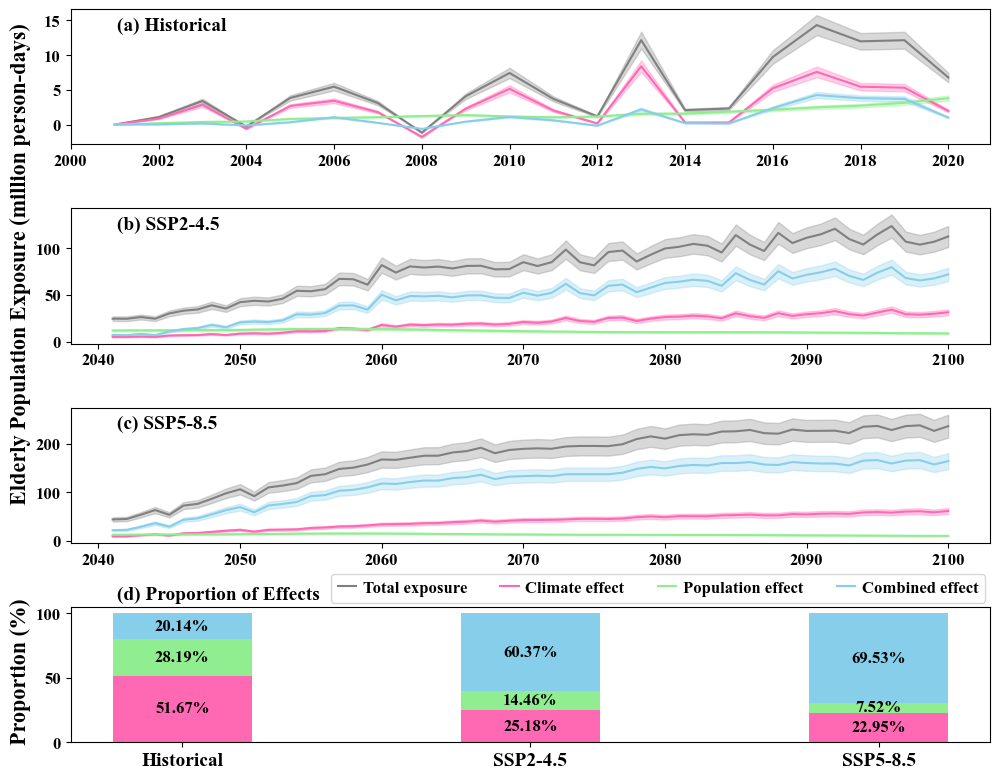

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Load data
file_path = 'Decompose_effects_summary_2001base.csv'
df = pd.read_csv(file_path)

# Calculate total exposure if not already calculated
if 'total_exposure' not in df.columns:
    df['total_exposure'] = df['climate_effect'] + df['combined_effect'] + df['population_effect']

# Define scenarios to plot
scenarios = [
    ('TM_historical', 2000, 2020),
    ('TM_SSP245', 2041, 2100),
    ('TM_SSP585', 2041, 2100)
]

# Labels for scenarios, needed for indexing correctly
labels = {
    'TM_historical': 'Historical',
    'TM_SSP245': 'SSP2-4.5',
    'TM_SSP585': 'SSP5-8.5'
}

# Color dictionary for plotting
colors = {
    'total_exposure': 'gray',
    'climate_effect': 'hotpink',
    'population_effect': 'lightgreen',
    'combined_effect': 'skyblue'
}

subplot_labels = ['(a)', '(b)', '(c)', '(d)']  # Subplot labels for clarity

# Initialize plot
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
formatter = FuncFormatter(lambda x, pos: f'{int(x/1e6)}')

# Plot each scenario
for i, (scenario, start_year, end_year) in enumerate(scenarios):
    ax = axes[i]
    scenario_data = df[(df['variable'] == scenario) & (df['year'] >= start_year) & (df['year'] <= end_year)]
    for effect in ['total_exposure', 'climate_effect', 'population_effect', 'combined_effect']:
        ax.plot(scenario_data['year'], scenario_data[effect], label=effect.capitalize(), color=colors[effect])
        uncertainty = scenario_data[effect] * 0.1
        ax.fill_between(scenario_data['year'], scenario_data[effect] - uncertainty, scenario_data[effect] + uncertainty, color=colors[effect], alpha=0.3)
    ax.text(0.05, 0.95, f"{subplot_labels[i]} {labels[scenario]}", transform=ax.transAxes, ha='left', va='top', fontsize=14)
    ax.yaxis.set_major_formatter(formatter)
    if scenario == 'TM_historical':
        ax.set_xticks(range(2000, 2021, 2))
        ax.set_xticklabels([str(year) for year in range(2000, 2021, 2)])

# Fourth subplot - Stacked Bar Chart
ax = axes[3]
summary = df.groupby('variable').agg({
    'total_exposure': 'sum',
    'climate_effect': 'sum',
    'population_effect': 'sum',
    'combined_effect': 'sum'
}).reset_index()

# Convert to percentages
for effect in ['climate_effect', 'population_effect', 'combined_effect']:
    summary[effect] = summary[effect] / summary['total_exposure'] * 100

# Reorder for bar chart according to specified order
summary['order'] = summary['variable'].apply(lambda x: labels[x])
summary.sort_values('order', inplace=True)

bar_width = 0.4
index = np.arange(len(scenarios))
bottom = np.zeros(len(scenarios))

for effect in ['climate_effect', 'population_effect', 'combined_effect']:
    bars = ax.bar(index, summary[effect], bar_width, bottom=bottom, label=effect.replace('_', ' ').capitalize(), color=colors[effect])
    for bar in bars:
        y_val = bar.get_y() + bar.get_height() / 2
        ax.text(bar.get_x() + bar.get_width() / 2, y_val, f"{bar.get_height():.2f}%", ha='center', va='center', color='black')
    bottom += summary[effect]

ax.set_xticks(index)
ax.set_xticklabels([labels[scenario] for scenario, _, _ in scenarios], fontsize=14)

fig.text(0.002, 0.66, 'Elderly Population Exposure (million person-days)', va='center', rotation='vertical', fontsize=16)
fig.text(0.002, 0.15, 'Proportion (%)', va='center', rotation='vertical', fontsize=16)

# Adjust layout for legend and overall tightness
ax.set_title(f"{subplot_labels[3]} Proportion of Effects", loc='left', fontsize=14, fontweight='bold', x=0.05)
fig.legend(lines, new_labels, loc='lower center', ncol=4, bbox_to_anchor=(0.3, 0.225, 0.7,1.01),handletextpad=0.4,handlelength=1.1)
plt.tight_layout(rect=[0.01, 0.005, 1, 1])  # Adjust layout to make room for legend
plt.show()
fig.savefig('decomposed_effects_plot.png', dpi=400)
